# Solution

## Goal
Use the 5 existing mixture experiments to (1) extract initial signal, and (2) recommend an efficient next batch of experiments to learn which ingredients (and interactions) drive rubber strength.

## Problem Statement
Rubber Experts are testing mixtures of 4 ingredients (percent by weight) that sum to 100:
- Polymer 1, Polymer 2
- Additive 1, Additive 2

They ran 5 experiments and observed strength (higher is better). Based on these results, recommend:
1. How many additional experiments to run next
2. Which ingredient proportions to test
3. A concrete list of proposed experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Reproducibility
rng = np.random.default_rng(42)

# Data from the prompt (percent by weight)
df = pd.DataFrame(
    {
        "experiment": [1, 2, 3, 4, 5],
        "polymer_1": [90, 0, 45, 60, 30],
        "polymer_2": [0, 90, 45, 30, 60],
        "additive_1": [10, 10, 0, 5, 5],
        "additive_2": [0, 0, 10, 5, 5],
        "strength": [16.5, 8.6, 12.6, 18.9, 9.8],
    }
).set_index("experiment")

ingredient_cols = ["polymer_1", "polymer_2", "additive_1", "additive_2"]
df["total_pct"] = df[ingredient_cols].sum(axis=1)

df

,polymer_1,polymer_2,additive_1,additive_2,strength,total_pct
experiment,,,,,,
1,90,0,10,0,16.5,100
2,0,90,10,0,8.6,100
3,45,45,0,10,12.6,100
4,60,30,5,5,18.9,100
5,30,60,5,5,9.8,100


## Key observation: this is a mixture experiment (not a classic 2×2 factorial)
In a classic factorial design, factors vary independently. Here, the ingredient percentages must satisfy a **mixture constraint**:
$$\text{polymer}_1 + \text{polymer}_2 + \text{additive}_1 + \text{additive}_2 = 100.$$

That constraint means changing one ingredient necessarily changes at least one other ingredient. So the most natural analysis/design toolset is **mixture DOE** (often modeled with Scheffé mixture polynomials).

### Practical implication
With only 5 runs, you can get directional guidance, but you *cannot* reliably estimate all interactions/curvature across 4 ingredients yet. The next step should be a **small, information-rich batch** of experiments that allows fitting at least a quadratic mixture model and estimating experimental noise (via replicates).

,polymer_1,polymer_2,additive_1,additive_2,strength,total_pct,total_additives,polymer_total,polymer_1_share,additive_1_share
experiment,,,,,,,,,,
1,90,0,10,0,16.5,100,10,90,1.000000,1.0
2,0,90,10,0,8.6,100,10,90,0.000000,1.0
3,45,45,0,10,12.6,100,10,90,0.500000,0.0
4,60,30,5,5,18.9,100,10,90,0.666667,0.5
5,30,60,5,5,9.8,100,10,90,0.333333,0.5


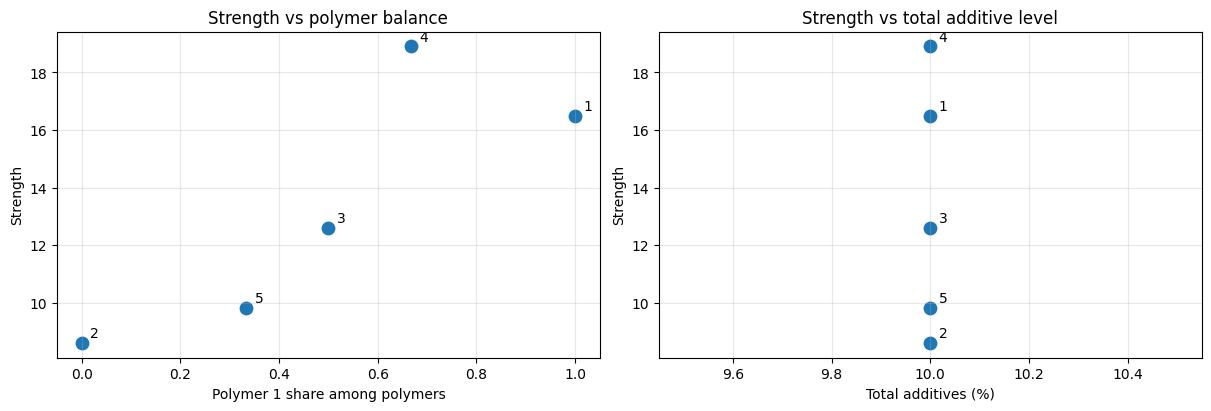

(np.int64(4),
 polymer_1     60.0
 polymer_2     30.0
 additive_1     5.0
 additive_2     5.0
 strength      18.9
 Name: 4, dtype: float64)

In [9]:
from IPython.display import display

# Basic validity check (mixtures should sum to 100)
if (df["total_pct"] != 100).any():
    raise ValueError("Ingredient percentages must sum to 100 for each experiment.")

# Derived features for interpretable EDA
df["total_additives"] = df["additive_1"] + df["additive_2"]
df["polymer_total"] = df["polymer_1"] + df["polymer_2"]

# Shares (handle 0/0 safely)
df["polymer_1_share"] = np.where(
    df["polymer_total"] > 0, df["polymer_1"] / df["polymer_total"], np.nan
)
df["additive_1_share"] = np.where(
    df["total_additives"] > 0, df["additive_1"] / df["total_additives"], np.nan
)

display(df)

# Quick EDA plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

axes[0].scatter(df["polymer_1_share"], df["strength"], s=80)
for i, r in df.iterrows():
    axes[0].annotate(str(i), (r["polymer_1_share"], r["strength"]), textcoords="offset points", xytext=(6, 4))
axes[0].set_xlabel("Polymer 1 share among polymers")
axes[0].set_ylabel("Strength")
axes[0].set_title("Strength vs polymer balance")
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df["total_additives"], df["strength"], s=80)
for i, r in df.iterrows():
    axes[1].annotate(str(i), (r["total_additives"], r["strength"]), textcoords="offset points", xytext=(6, 4))
axes[1].set_xlabel("Total additives (%)")
axes[1].set_ylabel("Strength")
axes[1].set_title("Strength vs total additive level")
axes[1].grid(True, alpha=0.3)

plt.show()

best_exp = df["strength"].idxmax()
best_row = df.loc[best_exp, :].reindex(ingredient_cols + ["strength"])
best_exp, best_row

## Modeling + experiment planning
### 1) Start simple: linear mixture model
A baseline model for mixture data is the **linear mixture model** (no intercept):
$$\mathbb{E}[Y] = \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \beta_4 x_4,$$
where $x_i$ are ingredient **proportions** that sum to 1.

With only 5 runs, this model is estimable and gives *directional* guidance (but uncertainty will be large).

### 2) What we ultimately want: quadratic mixture model
A common next step is the Scheffé quadratic mixture model:
$$\mathbb{E}[Y] = \sum_{i=1}^{4} \beta_i x_i + \sum_{i<j} \beta_{ij} x_i x_j.$$
For 4 ingredients, this has $4 + \binom{4}{2} = 10$ parameters, so we need **at least 10 distinct mixtures** (and preferably more, plus replicates).

### 3) Recommended next batch size
A practical first iteration is **~8 additional experiments**:
- ~6 new, information-rich mixtures (to learn interactions)
- ~2 replicates (to estimate experimental + measurement noise)

Below, we fit the linear model and then use a simple greedy D-optimal-style augmentation (over a reasonable candidate grid) to propose the next mixtures.

In [3]:
# Fit a linear mixture model (no intercept) using proportions
X_lin = df[ingredient_cols] / 100.0
y = df["strength"]

lin_model = sm.OLS(y, X_lin).fit()
lin_model.summary()

c:\Users\saiaj\Documents\GitHub\Applied-Statistics\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     2.409
Date:                Sat, 10 Jan 2026   Prob (F-statistic):              0.293
Time:                        17:38:36   Log-Likelihood:                -10.846
No. Observations:                   5   AIC:                             27.69
Df Residuals:                       2   BIC:                             26.52
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
polymer_1     20.1034      3.020      6.657      0.022       7.109      33.098
polymer_2      9.1701      3.020      3.036      0.094      -3.824      22.165
additive_1    -1.1594     19.960     -0.058      0.959     -87.042      84.723
additive_2     4.4120     20.058      0.220      0.846     -81.891      90.715
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.864
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.947
Skew:                           1.042   Prob(JB):                        0.623
Kurtosis:                       2.546   Cond. No.                     8.91e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.58e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Recommended next experiments (concrete list)
Because the current dataset is tiny, the goal of the next batch is to learn the surface efficiently while staying near practical, manufacturable regions.

### Design principles used
- **Replicate** the current best run (Experiment 4) to estimate noise and confirm the apparent improvement is real.
- Add points that vary:
  - polymer balance (P1 vs P2)
  - total additive level (e.g., 0%, 5%, 10%)
  - additive split (A1 vs A2)
- Keep candidate mixtures simple and interpretable (5% increments).

In the next code cell we generate a candidate set and pick an 8-run augmentation (6 new + 2 replicates). The output is a table you can hand to the lab.

In [7]:
def build_quadratic_mixture_features(x: pd.DataFrame) -> pd.DataFrame:
    """Scheffé quadratic mixture features: x_i and x_i*x_j for i<j (no intercept)."""
    x = x.copy()
    feats = {col: x[col].astype(float) for col in x.columns}
    cols = list(x.columns)
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            name = f"{cols[i]}:{cols[j]}"
            feats[name] = x[cols[i]] * x[cols[j]]
    return pd.DataFrame(feats, index=x.index)

def information_det(X: np.ndarray, ridge: float = 1e-10) -> float:
    """Determinant of X'X with tiny ridge for numerical stability."""
    XtX = X.T @ X
    XtX = XtX + ridge * np.eye(XtX.shape[0])
    return float(np.linalg.det(XtX))

# Candidate grid: 5% increments, totals sum to 100, additives <= 15% (plausible constraint)
step = 5
candidates = []
for p1 in range(0, 101, step):
    for p2 in range(0, 101 - p1, step):
        for a1 in range(0, 101 - p1 - p2, step):
            a2 = 100 - p1 - p2 - a1
            if a2 < 0 or (a2 % step) != 0:
                continue
            total_add = a1 + a2
            if total_add > 15:
                continue
            # avoid degenerate all-additive mixtures
            if (p1 + p2) == 0:
                continue
            candidates.append((p1, p2, a1, a2))

cand = pd.DataFrame(candidates, columns=ingredient_cols)
cand_prop = cand / 100.0

# Exclude existing runs from candidates to focus on new info points
existing_set = set(tuple(df.loc[i, ingredient_cols].astype(int).tolist()) for i in df.index)
mask_new = [tuple(row) not in existing_set for row in cand[ingredient_cols].astype(int).itertuples(index=False, name=None)]
cand_new = cand.loc[mask_new].reset_index(drop=True)
cand_new_prop = cand_new / 100.0

# Greedy augmentation: pick points to maximize det(X'X) for the quadratic feature matrix
X_existing = build_quadratic_mixture_features(X_lin).to_numpy()

selected = []
X_current = X_existing.copy()

n_new = 6
for _ in range(n_new):
    best_idx = None
    best_score = -np.inf
    # sample a subset for speed (candidate set can be large)
    # this keeps runtime reasonable in a notebook setting
    subset_idx = rng.choice(len(cand_new_prop), size=min(2000, len(cand_new_prop)), replace=False)
    for j in subset_idx:
        xj = cand_new_prop.loc[j:j, ingredient_cols]
        Xj = build_quadratic_mixture_features(xj).to_numpy()
        score = information_det(np.vstack([X_current, Xj]))
        if score > best_score:
            best_score = score
            best_idx = int(j)
    selected.append(best_idx)
    X_current = np.vstack([X_current, build_quadratic_mixture_features(cand_new_prop.loc[best_idx:best_idx, ingredient_cols]).to_numpy()])

selected_new = cand_new.loc[selected].copy()
selected_new.index = [f"new_{i+1}" for i in range(len(selected_new))]

# Add replicates: replicate best run (Exp 4) and a center-ish point (50/40/5/5 or nearest valid)
rep_best = df.loc[[4], ingredient_cols].copy()
rep_best.index = ["rep_best_exp4"]

center = pd.DataFrame([{
    "polymer_1": 50,
    "polymer_2": 40,
    "additive_1": 5,
    "additive_2": 5,
}])
center.index = ["rep_center"]

proposed = pd.concat([selected_new, rep_best, center], axis=0)
proposed["total_pct"] = proposed.sum(axis=1)

# Sanity check
assert (proposed["total_pct"] == 100).all(), "Proposed mixtures must sum to 100"

proposed

,polymer_1,polymer_2,additive_1,additive_2,total_pct
new_1,100,0,0,0,100
new_2,0,100,0,0,100
new_3,0,85,5,10,100
new_4,45,40,15,0,100
new_5,45,40,0,15,100
new_6,85,0,5,10,100
rep_best_exp4,60,30,5,5,100
rep_center,50,40,5,5,100


In [8]:
# Present proposed experiments in a lab-friendly format
proposed_out = proposed[ingredient_cols].copy()
proposed_out.insert(0, "experiment_label", proposed_out.index)
proposed_out.reset_index(drop=True, inplace=True)

# Also show a quick model-predicted strength from the linear model (very rough with N=5)
proposed_prop = proposed[ingredient_cols] / 100.0
proposed_out["pred_strength_linear"] = lin_model.predict(proposed_prop).values

# Sort to keep replicates at bottom
proposed_out

,experiment_label,polymer_1,polymer_2,additive_1,additive_2,pred_strength_linear
0,new_1,100,0,0,0,20.103426
1,new_2,0,100,0,0,9.170093
2,new_3,0,85,5,10,8.177811
3,new_4,45,40,15,0,12.540668
4,new_5,45,40,0,15,13.376382
5,new_6,85,0,5,10,17.471144
6,rep_best_exp4,60,30,5,5,14.975714
7,rep_center,50,40,5,5,13.882381


## What to tell Rubber Experts
### How many additional experiments?
Run **8 more experiments** in the next batch: **6 new mixtures + 2 replicates**. That’s usually enough to (a) estimate noise and (b) start fitting a quadratic mixture model in the next iteration.

### Which ingredients?
Keep all four ingredients in play, but vary them systematically:
- polymer balance (P1 vs P2)
- total additive % (0/5/10-ish)
- additive split (A1 vs A2)

### What exact experiments?
Use the table above as the recommended batch. After those results come back, refit a quadratic mixture model and then decide whether another smaller follow-on batch is needed.

## Notes / caveats
- With only 5 initial runs, any model-based prediction has high uncertainty. The value here is **learning efficiently**, not “declaring an optimum” prematurely.
- If there are practical constraints (e.g., additives must be ≥ 2% for processability), we should enforce them in the candidate grid before selecting points.